<a href="https://colab.research.google.com/github/a-mitani/pyro_code_examples/blob/main/mle_map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import random
import numpy as np
import torch
import torch.distributions.constraints as constraints
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist
import matplotlib.pyplot as plt

In [3]:
# 試行データ作成
def create_data(heads_num, tails_num):
    head = torch.tensor(1.0)
    tail = torch.tensor(0.0)
    data = []
    for _ in range(heads_num):
        data.append(head)
    for _ in range(tails_num):
        data.append(tail)
    random.shuffle(data)
    data = torch.tensor(data)
    return data

data = create_data(6, 4)

In [4]:
# 最適化計算用のヘルパー関数
#　引数として指定されたmodelの関数とguide関数を用いてELBOの最大化を行う
def optimize_param(model_fn, guide_fn):
    # グローバル変数として保存されているパラメータを削除
    pyro.clear_param_store()

    # Optimizerの定義と設定（Adamの利用が推奨されている）
    adam_params = {"lr": 0.001, "betas": (0.95, 0.999)}
    optimizer = Adam(adam_params)

    # 推論アルゴリズムとLoss値を定義
    # ここでは組み込みのELBOの符号反転をLoss値とする`Trace_ELBO()`を利用しています。
    svi = SVI(model_fn, guide_fn, optimizer, loss=Trace_ELBO())

    # 最適化の逐次計算
    # ここではAdamで勾配降下を1000回繰り返すことになる。
    n_steps = 1000
    losses = []
    for step in range(n_steps):
        loss = svi.step(data)
        losses.append(loss)
        if step % 100 == 0:
            print('#', end='')

    plt.plot(losses)
    plt.show()

## MAP推定

In [5]:
# MAP推定用に確率モデルの定義（ベイズ推定の際と全く同じことに注意）
def model_map(data):
    # 事前確率分布は裏表が平等に出る確率が高いだろうとして、α=2, β=2のベータ分布として設計。
    alpha0 = torch.tensor(2.0)
    beta0 = torch.tensor(2.0)
    f = pyro.sample("Theta", dist.Beta(alpha0, beta0))

    # 観測データのプレート定義
    with pyro.plate('observation'):
      pyro.sample('X', dist.Bernoulli(f), obs=data)

In [6]:
# MAP推定や最終推定は変分関数としてデルタ関数を仮定する。
def guide_delta(data):
    theta_opt = pyro.param("theta_opt", torch.tensor(0.5),
                       constraint=constraints.unit_interval)
    pyro.sample("Theta", dist.Delta(theta_opt))

##########

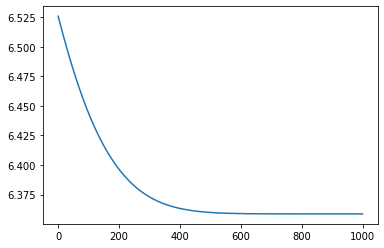

theta_opt = 0.583


In [7]:
#　MAP推定用のmodel関数とguide関数を指定して最適化を実施
optimize_param(model_map, guide_delta)

# 最適化後の変分パラメータを取得する
theta = pyro.param("theta_opt").item()
print("theta_opt = {:.3f}".format(theta))

 ## 最尤推定

In [8]:
# 最尤推定用に確率モデルの定義（ベイズ推定の際と全く同じことに注意）
def model_mle(data):
    # 事前確率分布は一定値（無情報）として一様分布を指定する
    f = pyro.sample("Theta", dist.Uniform(0.0, 1.0))

    # 観測データのプレート定義
    with pyro.plate('observation'):
      pyro.sample('X', dist.Bernoulli(f), obs=data)

##########

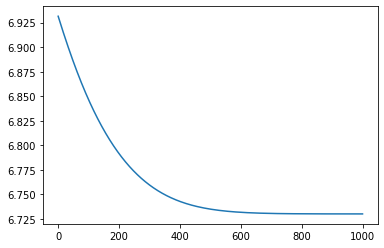

theta_opt = 0.600


In [9]:
#　MAP推定用のmodel関数とguide関数を指定して最適化を実施
# guideはMAP推定と同じくデルタ関数を利用。
optimize_param(model_mle, guide_delta)

# 最適化後の変分パラメータを取得する
theta = pyro.param("theta_opt").item()
print("theta_opt = {:.3f}".format(theta))

## Appendix

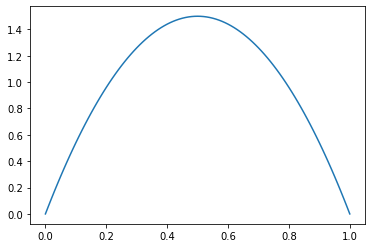

In [10]:
# 任意のパラメータでベータ関数をプロットする関数
def plot_beta_dist(alpha, beta):
    x_range = np.arange(0.0, 1.01, 0.01)
    estimated_dist = dist.Beta(alpha, beta)
    y = [estimated_dist.log_prob(torch.tensor([x])).exp() for x in x_range]
    plt.plot(x_range, y)

plot_beta_dist(2, 2)